# TrendPulse

## Contributors:

- Dilara Bursa
- Muhammad Uzair Rana
- Samer Eladad

## Required Libraries:

- os
- time
- pickle
- numpy
- pandas
- matplotlib
- seaborn
- scikit-learn
- torch (PyTorch)

## Introduction:

In recent years, dropshipping has gained significant traction, leading to increased competition and making product research increasingly challenging. As more individuals enter the market, finding the next "winning product" has become a complex task. This project aims to address this challenge by developing a prototype that serves as a sandbox for experimentation. By leveraging deep neural networks, we aim to assist dropshippers in selecting optimal products to sell. Users can input specific preferences, such as category, rating, number of ratings, and price, and the model will analyze the available products to offer five tailored recommendations. This tool is intended for beginner to intermediate dropshippers who have a basic understanding of the products they wish to sell.

To learn more about the project, feel free to check our repo: [TrendPulse GitHub Repository](https://github.com/SamerEladad/TrendPulse).

## Project Scope:

(write about project scope)

#### Import Libraries:

In [41]:
import os
import time
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score, auc, accuracy_score, roc_curve, precision_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR, MultiplicativeLR, ExponentialLR


## Data Research:

(write about the data research phase, web scraping and how we have come to the used dataset)

#### Import Data:

In [2]:
# Load the clean dataset
# Adjust file path as needed
df = pd.read_csv(r'/Users/samer/Documents/github_repos/TrendPulse/data/clean/Combined_Amazon_Dataset_Cleaned.csv')

#### Data Exploration:

In [4]:
# Display the first five rows of the dataset
df.head()

,name,main_category,sub_category,link,ratings,no_of_ratings,discount_price,actual_price
0,Bangalore Refinery 24k (999.9) 10 gm Yellow Go...,accessories,Jewellery,https://www.amazon.in/Bangalore-Refinery-999-9...,4.6,1186,64649.0,72800.0
1,Bangalore Refinery 24k (999.9) 2 gm Yellow Gol...,accessories,Jewellery,https://www.amazon.in/Bangalore-Refinery-999-9...,4.6,4392,13145.0,13200.0
2,Bangalore Refinery 999 Purity Silver Bar 1 Kg,accessories,Jewellery,https://www.amazon.in/Bangalore-Refinery-999-P...,4.3,218,73672.0,78000.0
3,Bangalore Refinery 999 Purity Silver Bar 500 Gram,accessories,Jewellery,https://www.amazon.in/Bangalore-Refinery-Purit...,4.4,231,37028.0,41000.0
4,Bangalore Refinery 999 Purity Silver Bar 100 Gram,accessories,Jewellery,https://www.amazon.in/Bangalore-Refinery-Purit...,4.5,837,7663.0,8500.0


In [5]:
# Print the columns of the dataframe
print(df.columns)

Index(['name', 'main_category', 'sub_category', 'link', 'ratings',
       'no_of_ratings', 'discount_price', 'actual_price'],
      dtype='object')


In [8]:
# Number of rows in the dataset
number_of_rows = df.shape[0]
print(f"Number of rows in the dataset: {number_of_rows}")

Number of rows in the dataset: 37049


In [7]:
# Printing the number of missing values in each column (is 0 because the data has already been cleaned)
missing_values = df.isnull().sum()
print(missing_values)

name              0
main_category     0
sub_category      0
link              0
ratings           0
no_of_ratings     0
discount_price    0
actual_price      0
dtype: int64


In [10]:
# Print the column types of the cleaned dataset
column_types = df.dtypes
print(column_types)

name               object
main_category      object
sub_category       object
link               object
ratings           float64
no_of_ratings       int64
discount_price    float64
actual_price      float64
dtype: object


#### Data Cleaning:

(write about the data cleaning phase, examples:
- removed ',' and currency symbol in order to change the price to float
- removed products with missing values
- removed product image link column since it is not needed)

#### Data Visualization:

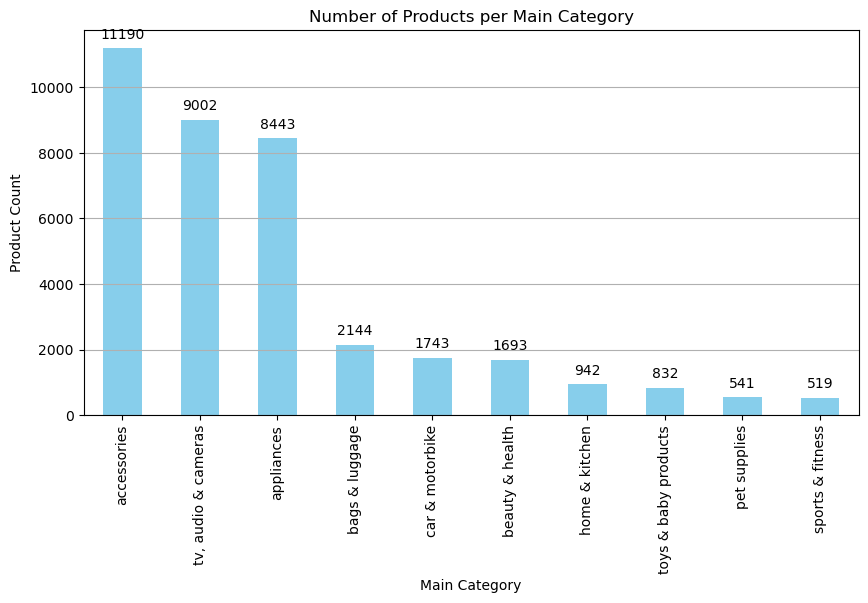

In [16]:
# Plotting the number of products per main category in the dataset
plt.figure(figsize=(10, 5))
ax = df['main_category'].value_counts(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Number of Products per Main Category')
plt.xlabel('Main Category')
plt.ylabel('Product Count')
plt.xticks(rotation=90)
plt.grid(axis='y')  # Adding grid lines on the y-axis

# Adding the number above each bar
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

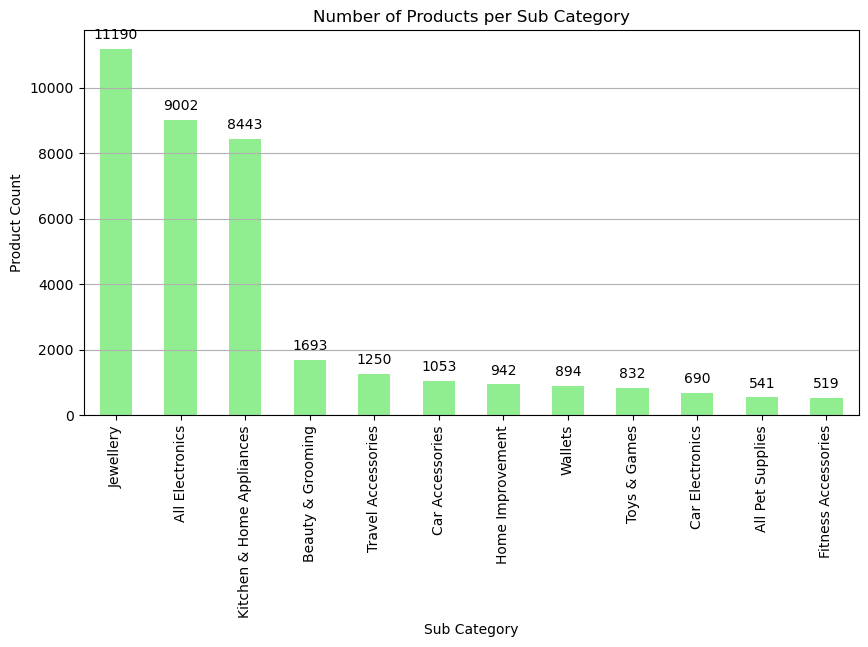

In [17]:
# Plotting the number of products per sub category in the dataset
plt.figure(figsize=(10, 5))
ax = df['sub_category'].value_counts(ascending=False).plot(kind='bar', color='lightgreen')
plt.title('Number of Products per Sub Category')
plt.xlabel('Sub Category')
plt.ylabel('Product Count')
plt.xticks(rotation=90)
plt.grid(axis='y')  # Adding grid lines on the y-axis

# Adding the number above each bar
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

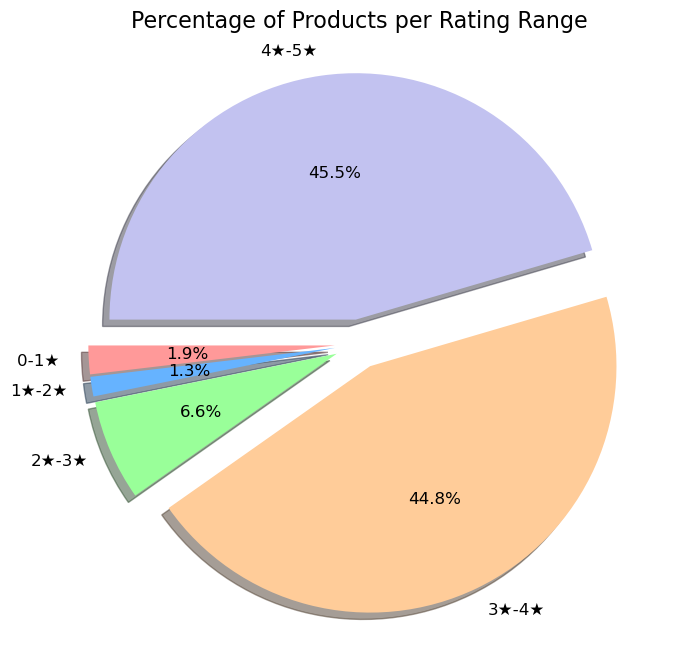

In [39]:
# Create bins for the rating ranges
bins = [0, 1, 2, 3, 4, 5]
labels = ['0-1★ ', '1★-2★', '2★-3★', '3★-4★', '4★-5★']
df['rating_range'] = pd.cut(df['ratings'], bins=bins, labels=labels, include_lowest=True)

# Plotting the number of products per rating range as a pie chart
plt.figure(figsize=(8, 8))
rating_counts = df['rating_range'].value_counts(sort=False)

colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#c2c2f0']
explode = (0.1, 0.1, 0.1, 0.1, 0.1)  # Slightly explode all slices
plt.pie(rating_counts, labels=rating_counts.index, autopct='%1.1f%%', colors=colors, 
        explode=explode, shadow=True, startangle=180, textprops={'fontsize': 12})

plt.title('Percentage of Products per Rating Range', fontsize=16)
plt.show()

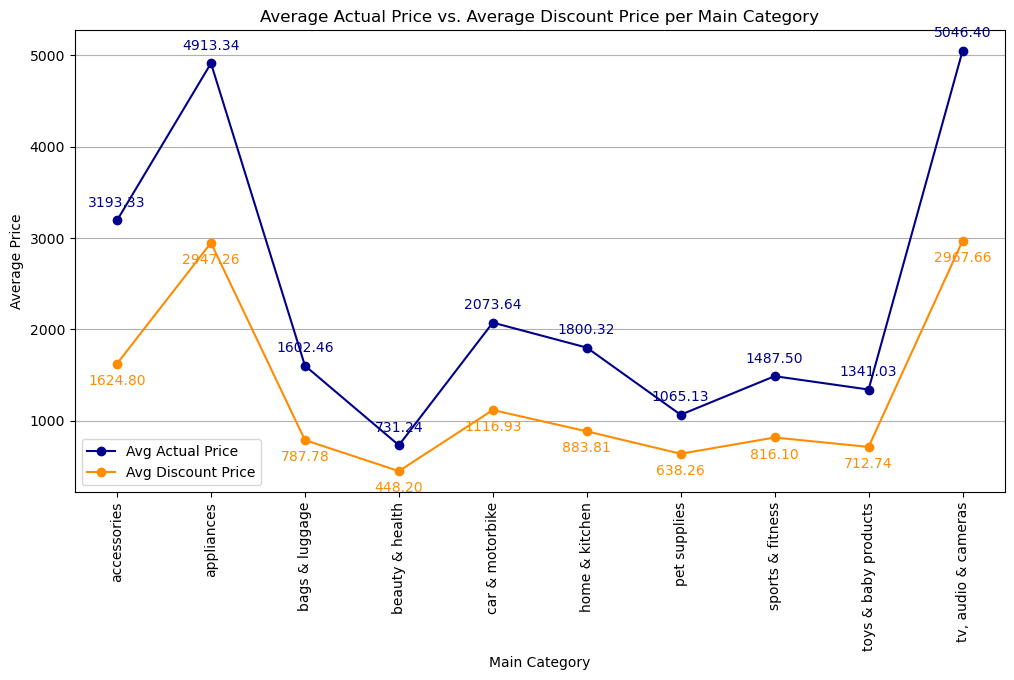

In [48]:
# Calculate the averages per main_category
avg_prices_main = df.groupby('main_category')[['actual_price', 'discount_price']].mean()

# Plotting
plt.figure(figsize=(12, 6))
categories = avg_prices_main.index

# Plotting the actual_price
plt.plot(categories, avg_prices_main['actual_price'], 'o-', label='Avg Actual Price', color='darkblue')

# Plotting the discount_price
plt.plot(categories, avg_prices_main['discount_price'], 'o-', label='Avg Discount Price', color='darkorange')

# Adding titles and labels
plt.title('Average Actual Price vs. Average Discount Price per Main Category')
plt.xlabel('Main Category')
plt.ylabel('Average Price')
plt.xticks(rotation=90)
plt.grid(axis='y')  # Adding grid lines on the y-axis

# Adding legend
plt.legend()

# Adding the number above each point
for i, category in enumerate(categories):
    plt.annotate(f'{avg_prices_main["actual_price"].iloc[i]:.2f}', 
                 (category, avg_prices_main['actual_price'].iloc[i]), 
                 textcoords="offset points", xytext=(0,10), ha='center', color='darkblue')
    plt.annotate(f'{avg_prices_main["discount_price"].iloc[i]:.2f}', 
                 (category, avg_prices_main['discount_price'].iloc[i]), 
                 textcoords="offset points", xytext=(0,-15), ha='center', color='darkorange')

# Display the plot
plt.show()

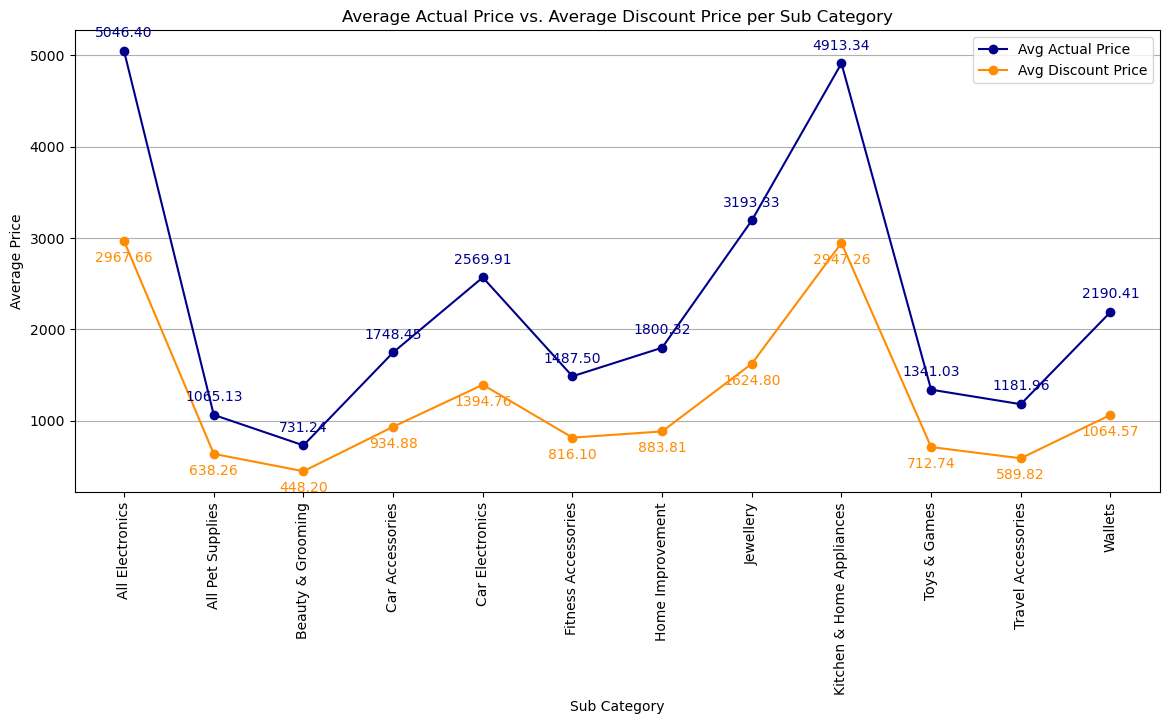

In [51]:
# Calculate the averages per sub_category
avg_prices_sub = df.groupby('sub_category')[['actual_price', 'discount_price']].mean()

# Plotting
plt.figure(figsize=(14, 6))
categories = avg_prices_sub.index

# Plotting the actual_price
plt.plot(categories, avg_prices_sub['actual_price'], 'o-', label='Avg Actual Price', color='darkblue')

# Plotting the discount_price
plt.plot(categories, avg_prices_sub['discount_price'], 'o-', label='Avg Discount Price', color='darkorange')

# Adding titles and labels
plt.title('Average Actual Price vs. Average Discount Price per Sub Category')
plt.xlabel('Sub Category')
plt.ylabel('Average Price')
plt.xticks(rotation=90)
plt.grid(axis='y')  # Adding grid lines on the y-axis

# Adding legend
plt.legend()

# Adding the number above each point
for i, category in enumerate(categories):
    plt.annotate(f'{avg_prices_sub["actual_price"].iloc[i]:.2f}', 
                 (category, avg_prices_sub['actual_price'].iloc[i]), 
                 textcoords="offset points", xytext=(0,10), ha='center', color='darkblue')
    plt.annotate(f'{avg_prices_sub["discount_price"].iloc[i]:.2f}', 
                 (category, avg_prices_sub['discount_price'].iloc[i]), 
                 textcoords="offset points", xytext=(0,-15), ha='center', color='darkorange')

# Display the plot
plt.show()

## AI Model:

### Training, Validation and Testing:

##### Paths and Directories

In [ ]:
# Creating directories and paths for the model weights and files for the experiment

main_dir = 'new_exp'
experiment = 'lable_encoded_exp_2_feat_engineer'
exp_dir = os.path.join(main_dir, experiment)
weights_dir = os.path.join(exp_dir, 'model_weights')
log_path = os.path.join(exp_dir, 'Training_log.txt')
os.makedirs(weights_dir, exist_ok=True)

##### Separating Train and Test Data for complete isolation and avoid data leakage

In [ ]:
df = pd.read_csv('Combined_Amazon_Dataset_Cleaned.csv')

df = df.rename(columns={'name': 'product'})

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['main_category'], random_state=42)
train_df.to_excel('Train_data.xlsx',  index=False)
test_df.to_excel('Test_data.xlsx', index= False)

##### Preprocessing the separated Training Data for training and validation

In [ ]:
# read the separated training data into df

df = pd.read_excel('Train_data.xlsx')

In [ ]:
# Step 1: Distribute the entire data in 3 categories for classification.

# Class_0 -> (rating= 1-2.5), Class_1 -> (rating = 2.6-4.0), Class_2 -> (rating = 4.1 - 5.0)

# Create the int_rating column using a lambda function with three categories of ratings

df['int_rating'] = df['ratings'].apply(lambda x: 0 if x <= 2.5 else (1 if x <= 4.0 else 2))


In [ ]:
### Step 2: Create Lable Encodings for categorical Columns (main_category, sub_category)

# Create a LabelEncoder object
le = LabelEncoder()

# Fit the LabelEncoder to the main_category column and transform it
df['encoded_main_category'] = le.fit_transform(df['main_category'])

# Save the LabelEncoder object to a file
with open(os.path.join(exp_dir, 'main_category_label_encoder.pkl'), 'wb') as f:
    pickle.dump(le, f)

# Create a LabelEncoder object for sub_category
le_subcategory = LabelEncoder()

# Fit the LabelEncoder to the sub_category column and transform it
df['encoded_sub_category'] = le_subcategory.fit_transform(df['sub_category'])

# Save the LabelEncoder object to a file
with open(os.path.join(exp_dir, 'sub_category_label_encoder.pkl'), 'wb') as f:
    pickle.dump(le_subcategory, f)


In [ ]:
# Convert prices from rupees to USD
df['actual_price'] = df['actual_price'] / 83
df['discount_price'] = df['discount_price'] / 83

In [ ]:
### Create engineered features to create some features that are corelated with class column

# Calculate category-specific rating density
df['rating_density'] = df.groupby('encoded_main_category')['no_of_ratings'].transform('mean') / df.groupby('encoded_main_category')['no_of_ratings'].transform('count')

# Calculate average rating per category
df['avg_rating_per_category'] = df.groupby('encoded_main_category')['ratings'].transform('mean')

df['weighted_discount_price'] = df['ratings'] * df['discount_price']
df['weighted_actual_price'] = df['ratings'] * df['actual_price']

main_category_avg_price = df.groupby('encoded_main_category')['discount_price'].mean()
df['rating_adjusted_discount_price'] = df['discount_price'] / df['encoded_main_category'].map(main_category_avg_price) * df['ratings']

df['rating_importance'] = df['ratings'] * df['no_of_ratings']


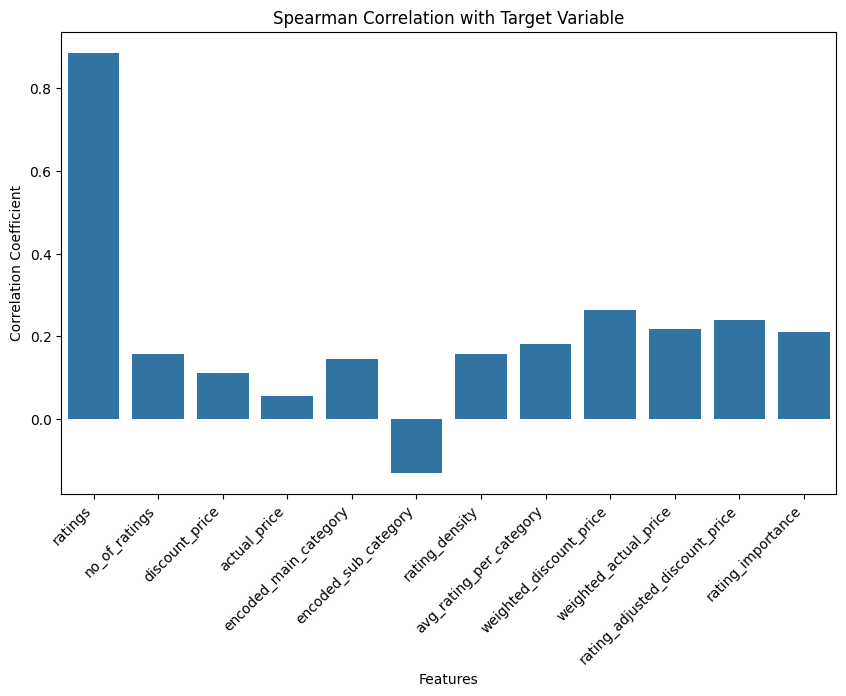

In [ ]:
### Calculate Spearman correlation of original features and engineered features
### with Target feature (int_rating)

corr_with_target = df.drop(['int_rating', 'product', 'link', 'main_category', 'sub_category'], axis=1).corrwith(df['int_rating'], method='spearman')

# Plot the correlation
plt.figure(figsize=(10, 6))
sns.barplot(x=corr_with_target.index, y=corr_with_target.values)
plt.title('Spearman Correlation with Target Variable')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
#### ---- Important -------

# Save the dataframe to file containing encoded and original information for Post Processing

df.to_excel(os.path.join(exp_dir, 'Train_Data_3_classes_encoded.xlsx'), index=False)

In [ ]:
### Step 3: Normalize numerical columns

# Initialize the scaler
scaler = StandardScaler()


df[['ratings', 'no_of_ratings', 'actual_price', 'discount_price',
    'rating_density', 'avg_rating_per_category', 'weighted_discount_price',
    'weighted_actual_price', 'rating_adjusted_discount_price',
    'rating_importance']] = scaler.fit_transform(df[['ratings', 'no_of_ratings', 'actual_price', 'discount_price',
                                                                                       'rating_density', 'avg_rating_per_category', 'weighted_discount_price',
                                                                                       'weighted_actual_price', 'rating_adjusted_discount_price','rating_importance']])


In [ ]:
# Features and target
X = df.drop(columns=['int_rating', 'product', 'link', 'main_category', 'sub_category', 'ratings'])
y = df['int_rating']

# Stratified split to maintain the distribution of int_rating across train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Combine features and target back into DataFrames
train_df = pd.concat([X_train, y_train], axis=1)
val_df = pd.concat([X_val, y_val], axis=1)


In [ ]:
# Save the finalized train data to file for retraining if needed

train_df.to_excel(os.path.join(exp_dir,'encoded_train_data.xlsx'), index=False)

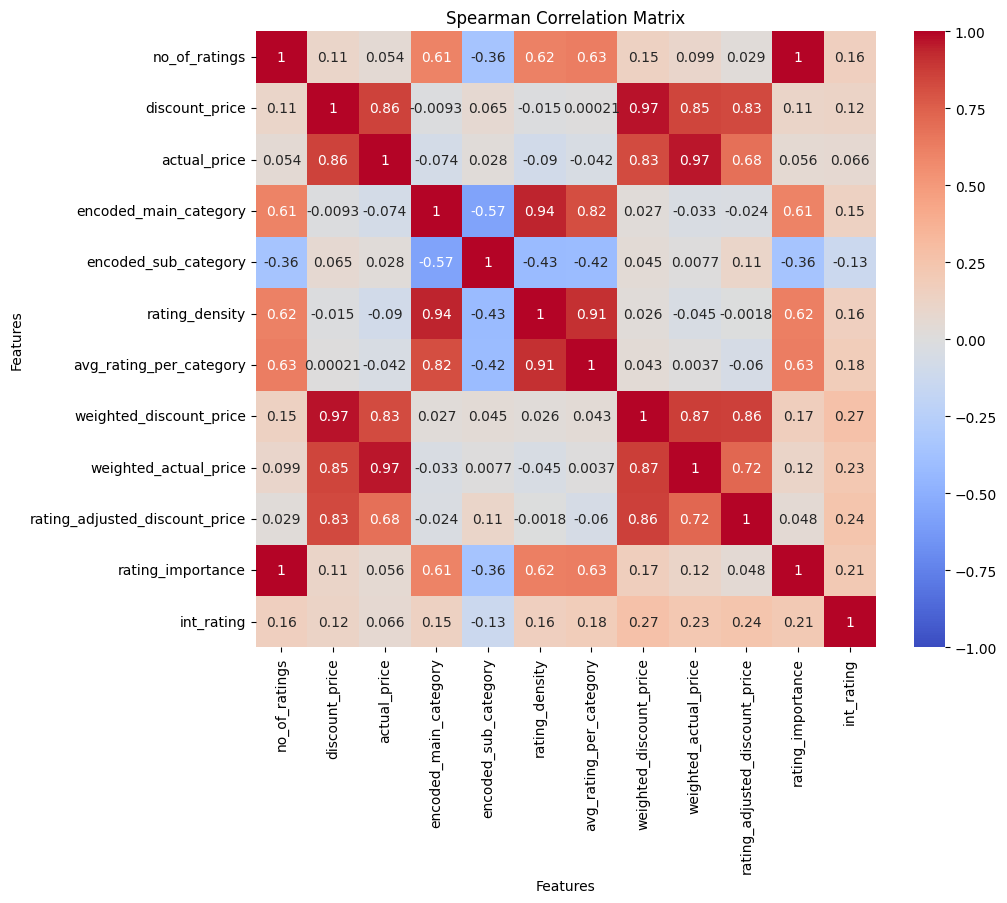

In [ ]:
### Traininng Feature insight by visualizing spearmann corelation matrix of all features

# Calculate Spearman correlation
corr_matrix = train_df.corr(method='spearman')

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Spearman Correlation Matrix')
plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

In [ ]:
# Define Metric functions for metric tracking and visualization

def compute_accuracy(predictions, labels):
    _, predicted = torch.max(predictions, 1)
    return accuracy_score(labels.cpu().numpy(), predicted.cpu().numpy())

def compute_auc(predictions, labels, num_classes):
    predictions_prob = F.softmax(predictions, dim=1).cpu().numpy()
    labels = labels.cpu().numpy()
    if num_classes == 2:
        return roc_auc_score(labels, predictions_prob[:, 1])  # For binary classification
    else:
        return roc_auc_score(labels, predictions_prob, multi_class='ovr')  # For multi-class classification
    
def logging(log_path, log_text):
    with open(log_path, 'a') as file:
        file.write(log_text + '\n')
        

def calculate_average_auc(probs, labels, num_classes=3):
    # Detach tensors and convert them to NumPy arrays
    probs_np = probs.detach().numpy()
    labels_np = labels.detach().numpy()
    
    aucs = []
    labels_one_hot = F.one_hot(torch.tensor(labels_np), num_classes).numpy()  # Convert labels to one-hot encoding
    for i in range(num_classes):
        auc = roc_auc_score(labels_one_hot[:, i], probs_np[:, i])
        aucs.append(auc)
    return np.mean(aucs)  # Return the average AUC


def calculate_precision_f1(probs, labels, num_classes=3):
    # Detach tensors and convert them to NumPy arrays
    probs_np = probs.detach().numpy()
    labels_np = labels.detach().numpy()

    # Convert probabilities to predicted class labels
    preds = probs_np.argmax(axis=1)

    # Calculate precision and F1 score for each class
    precision = precision_score(labels_np, preds, average='weighted', zero_division=1)
    f1 = f1_score(labels_np, preds, average='weighted')
    
    return precision, f1

# Function to calculate and plot AUC-ROC
def calculate_and_plot_average_auc_roc(test_labels, test_probs, num_classes):
    # Binarize the labels for all classes
    true_labels_one_hot = np.eye(num_classes)[test_labels]
    
    # Calculate the micro-average ROC curve and AUC
    fpr, tpr, _ = roc_curve(true_labels_one_hot.ravel(), test_probs.ravel())
    average_auc = roc_auc_score(true_labels_one_hot, test_probs, average='micro')

    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f'Average AUC (micro) = {average_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average ROC Curve')
    plt.legend(loc='lower right')
    plt.show()
    
    return average_auc


def plot_confusion_matrix(test_labels, test_preds, class_names):
    """
    Plots the confusion matrix.
    
    Args:
    - test_labels: True labels for the test data.
    - test_preds: Predicted labels for the test data.
    - class_names: List of class names.
    """
    # Compute the confusion matrix
    cm = confusion_matrix(test_labels, test_preds)
    
    # Create a DataFrame for better visualization
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
    
    # Plot the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()



def plot_precision_f1(test_probs, test_labels, num_classes=3):
    """
    Function to calculate and plot precision and F1 score for each class.
    
    Args:
        test_probs (torch.Tensor): The predicted probabilities from the model.
        test_labels (torch.Tensor): The true labels.
        num_classes (int): Number of classes in the classification task.
    """

    # Convert tensors to numpy arrays
    probs_np = test_probs
    labels_np = test_labels

    # Get the predicted class by finding the class with the maximum probability
    preds = probs_np.argmax(axis=1)

    # Calculate precision and F1 score for each class
    precision_per_class = precision_score(labels_np, preds, average=None, labels=range(num_classes))
    f1_per_class = f1_score(labels_np, preds, average=None, labels=range(num_classes))

    # Define class names
    classes = [f'Class {i}' for i in range(num_classes)]

    # Plotting the Precision
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.bar(classes, precision_per_class, color='blue')
    plt.ylim(0, 1)
    plt.title('Precision per Class')
    plt.xlabel('Classes')
    plt.ylabel('Precision')

    # Plotting the F1 Score
    plt.subplot(1, 2, 2)
    plt.bar(classes, f1_per_class, color='green')
    plt.ylim(0, 1)
    plt.title('F1 Score per Class')
    plt.xlabel('Classes')
    plt.ylabel('F1 Score')

    plt.tight_layout()
    plt.show()
    
    
def plot_multiclass_roc(y_true, y_pred, n_classes=3):
    # Binarize the output
    y_true_bin = label_binarize(y_true, classes=[*range(n_classes)])
    y_pred_bin = label_binarize(y_pred, classes=[*range(n_classes)])
    
    plt.figure()
    
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multiclass Classification')
    plt.legend(loc='lower right')
    plt.show()


##### Model and Dataset class Definition

In [ ]:
###  Create Model class to define Model architecture
 
class RecommendationModel(nn.Module):
    def __init__(self, input_dim):
        super(RecommendationModel, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, 256)
        self.dropout1 = nn.Dropout(p=0.3)
        
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(p=0.3)
        
        self.fc3 = nn.Linear(128, 64)
        self.dropout3 = nn.Dropout(p=0.3)
        
        self.fc4 = nn.Linear(64, 32)
        self.dropout4 = nn.Dropout(p=0.3)
        
        self.fc5 = nn.Linear(32, 3)
        
    def forward(self, features):
        x = torch.relu(self.fc1(features))
        x = self.dropout1(x)
        
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        
        x = torch.relu(self.fc3(x))
        x = self.dropout3(x)
        
        x = torch.relu(self.fc4(x))
        x = self.dropout4(x)
        
        output = self.fc5(x)
        return output

In [ ]:
### Define Custom Dataset Class for processing and Packing feature data for Model

class CustomDataset(Dataset):
    def __init__(self, df, feature_cols, target_col):
        self.df = df
        self.feature_cols = feature_cols
        self.target_col = target_col

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        features = torch.tensor(self.df[self.feature_cols].iloc[idx].values)
        target = torch.tensor(self.df[self.target_col].iloc[idx])
        return features, target

##### Dataset and DataLoader

In [ ]:
### Create Training and Validation Datasets and subsequent DataLoaders

feature_cols = train_df.columns.drop(['int_rating']).tolist()
target_col = 'int_rating'

train_dataset = CustomDataset(train_df, feature_cols, target_col)
val_dataset = CustomDataset(val_df, feature_cols, target_col)

# Create DataLoaders for batching
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
feature_cols

['no_of_ratings',
 'discount_price',
 'actual_price',
 'encoded_main_category',
 'encoded_sub_category',
 'rating_density',
 'avg_rating_per_category',
 'weighted_discount_price',
 'weighted_actual_price',
 'rating_adjusted_discount_price',
 'rating_importance']

##### Model initialization and Training parameters

In [ ]:
### Model Inititialization and learning parameters definition

# Initialize the model

input_dim = len(train_df.columns) - 1

model = RecommendationModel(input_dim)

# Define loss function
criterion = nn.CrossEntropyLoss()  # Since it's a multi-class classification problem

num_epochs = 200
initial_lr = 0.001
exponent = 0.98
optimizer = optim.Adam(model.parameters(), lr=initial_lr, weight_decay=3e-3)
scheduler = ExponentialLR(optimizer, gamma=exponent)

In [ ]:
print(model)

RecommendationModel(
  (fc1): Linear(in_features=11, out_features=256, bias=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (dropout3): Dropout(p=0.3, inplace=False)
  (fc4): Linear(in_features=64, out_features=32, bias=True)
  (dropout4): Dropout(p=0.3, inplace=False)
  (fc5): Linear(in_features=32, out_features=3, bias=True)
)


##### Training and Validation Loop

In [ ]:
import torch
import torch.nn.functional as F
import time
import numpy as np
import pandas as pd
import os

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Move model to the appropriate device
model = model.to(device)

# Initialize best validation loss
best_val_loss = float('inf')

# Variable to store probabilities when the best model is saved
best_epoch_train_probs = None
best_epoch_train_labels = None
best_epoch_val_probs = None
best_epoch_val_labels = None

epoch_count = 0

for epoch in range(num_epochs):
    print(f'Epoch: {epoch + 1}/{num_epochs}')
    
    start_time = time.time()  # Start epoch timer
    
    model.train()  # Set model to training mode
    running_loss = 0.0
    train_probs = []
    train_label_list = []
    
    # Training loop
    for batch in train_loader:
        tr_features, tr_labels= batch
        
        tr_features = tr_features.to(device).float()
        tr_labels = tr_labels.to(device)
        
        
        optimizer.zero_grad()  # Clear gradients
        
        # Forward pass
        outputs = model(tr_features)

        loss = criterion(outputs, tr_labels)  # Compute loss
        
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        
        running_loss += loss.item()
        
        # Apply softmax to get probabilities
        probs = F.softmax(outputs, dim=1)
        train_probs.append(probs.cpu())
        train_label_list.append(tr_labels.cpu())
    
    # Calculate training metrics
    train_probs = torch.cat(train_probs)
    train_labels = torch.cat(train_label_list)
    train_loss = running_loss / len(train_loader)
    train_accuracy = (train_probs.argmax(dim=1) == train_labels).float().mean().item()
    train_precision, train_f1 = calculate_precision_f1(train_probs, train_labels)

    # Validation loop
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    val_probs = []
    val_label_list = []
    with torch.no_grad():  # Disable gradient computation
        for batch in val_loader:
            v_features, v_labels= batch
                        
            v_features = v_features.to(device).float()
            v_labels = v_labels.to(device)
                        
            outputs = model(v_features)
            loss = criterion(outputs, v_labels)
            val_loss += loss.item()
            
            # Apply softmax to get probabilities
            probs = F.softmax(outputs, dim=1)
            val_probs.append(probs.cpu())
            val_label_list.append(v_labels.cpu())
    
    # Calculate validation metrics
    val_probs = torch.cat(val_probs)
    val_labels = torch.cat(val_label_list)
    val_loss = val_loss / len(val_loader)
    val_accuracy = (val_probs.argmax(dim=1) == val_labels).float().mean().item()
    val_precision, val_f1 = calculate_precision_f1(val_probs, val_labels)

    # Calculate epoch time
    epoch_time = time.time() - start_time
    
    # Learning rate
    lr = optimizer.param_groups[0]['lr']
    
    # Print metrics
    print(f'Epoch [{epoch+1}/{num_epochs}] | '
          f'Train Loss: {train_loss:.4f} | '
          f'Val Loss: {val_loss:.4f} | '
          f'Train Accuracy: {train_accuracy:.4f} | '
          f'Val Accuracy: {val_accuracy:.4f} | '
          f'Train Precision: {train_precision:.4f} | '
          f'Val Precision: {val_precision:.4f} | '
          f'Train F1: {train_f1:.4f} | '
          f'Val F1: {val_f1:.4f} | '
          f'Epoch Time: {epoch_time:.2f}s | '
          f'Learning Rate: {lr:.6f}')
    
    # Learning rate scheduler step
    scheduler.step()
    
    # Save the best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), os.path.join(weights_dir,'best_model.pth'))
        print(f'\nSaved new best model with Val_Loss: {val_loss:.3f}\n')
        epoch_count = 0
        
        # Store the probabilities of the best epoch
        best_epoch_train_probs = train_probs.detach().numpy()
        best_epoch_train_labels = train_labels.detach().numpy()
        best_epoch_val_probs = val_probs.detach().numpy()
        best_epoch_val_labels = val_labels.detach().numpy()
        
    if epoch_count == 15:
        print(f'Validation loss has not improved for {epoch_count} epochs. Training Finished !!!')
        break
    epoch_count += 1

# After training, save the probabilities of the best epoch
if best_epoch_train_probs is not None:
    train_prob_df = pd.DataFrame(best_epoch_train_probs, columns=[f'prob_class_{i}' for i in range(best_epoch_train_probs.shape[1])])
    train_prob_df['labels'] = best_epoch_train_labels

    val_prob_df = pd.DataFrame(best_epoch_val_probs, columns=[f'prob_class_{i}' for i in range(best_epoch_val_probs.shape[1])])
    val_prob_df['labels'] = best_epoch_val_labels

    # Save dataframes to Excel
    train_prob_df.to_excel(os.path.join(exp_dir,'best_epoch_train_data.xlsx'), index=False)
    val_prob_df.to_excel(os.path.join(exp_dir,'best_epoch_val_data.xlsx'), index=False)

print('Training Complete !!!')


Using device: cuda
Epoch: 1/200
Epoch [1/200] | Train Loss: 0.8363 | Val Loss: 0.8195 | Train Accuracy: 0.5366 | Val Accuracy: 0.5371 | Train Precision: 0.5569 | Val Precision: 0.6153 | Train F1: 0.5222 | Val F1: 0.4473 | Epoch Time: 20.83s | Learning Rate: 0.001000

Saved new best model with Val_Loss: 0.820

Epoch: 2/200
Epoch [2/200] | Train Loss: 0.8106 | Val Loss: 0.7898 | Train Accuracy: 0.5657 | Val Accuracy: 0.5535 | Train Precision: 0.5883 | Val Precision: 0.6325 | Train F1: 0.5474 | Val F1: 0.4786 | Epoch Time: 20.91s | Learning Rate: 0.000980

Saved new best model with Val_Loss: 0.790

Epoch: 3/200
Epoch [3/200] | Train Loss: 0.7655 | Val Loss: 0.6741 | Train Accuracy: 0.5980 | Val Accuracy: 0.6587 | Train Precision: 0.6181 | Val Precision: 0.6931 | Train F1: 0.5827 | Val F1: 0.6366 | Epoch Time: 20.65s | Learning Rate: 0.000960

Saved new best model with Val_Loss: 0.674

Epoch: 4/200
Epoch [4/200] | Train Loss: 0.6676 | Val Loss: 0.6058 | Train Accuracy: 0.6699 | Val Accurac

# ---------------------------------------------------

##### Evaluation on Test Data

In [ ]:

# read the separated test data into test_df

test_df = pd.read_excel('Test_data.xlsx')

# Load the main category encoding dictionary
with open(os.path.join(exp_dir,'main_category_label_encoder.pkl'), 'rb') as f:
    main_category_label_encoder = pickle.load(f)

# Load the subcategory encoding dictionary
with open(os.path.join(exp_dir,'sub_category_label_encoder.pkl'), 'rb') as f:
    sub_category_label_encoder = pickle.load(f)


# Encode the main categories using the loaded dictionary
test_df['encoded_main_category'] = main_category_label_encoder.transform(test_df['main_category'])
# Encode the subcategories using the loaded dictionary
test_df['encoded_sub_category'] = sub_category_label_encoder.transform(test_df['sub_category'])

test_df['encoded_main_category'] = test_df['encoded_main_category'].fillna(-1).astype(int)
test_df['encoded_sub_category'] = test_df['encoded_sub_category'].fillna(-1).astype(int)


# Create the int_rating column using a lambda function with three categories of ratings
test_df['int_rating'] = test_df['ratings'].apply(lambda x: 0 if x <= 2.5 else (1 if x <= 4.0 else 2))


# Convert prices from rupees to USD
test_df['actual_price'] = test_df['actual_price'] / 83
test_df['discount_price'] = test_df['discount_price'] / 83

# Calculate category-specific rating density
test_df['rating_density'] = test_df.groupby('encoded_main_category')['no_of_ratings'].transform('mean') / test_df.groupby('encoded_main_category')['no_of_ratings'].transform('count')

# Calculate average rating per category
test_df['avg_rating_per_category'] = test_df.groupby('encoded_main_category')['ratings'].transform('mean')

test_df['weighted_discount_price'] = test_df['ratings'] * test_df['discount_price']
test_df['weighted_actual_price'] = test_df['ratings'] * test_df['actual_price']

main_category_avg_price = df.groupby('encoded_main_category')['discount_price'].mean()
test_df['rating_adjusted_discount_price'] = test_df['discount_price'] / test_df['encoded_main_category'].map(main_category_avg_price) * test_df['ratings']

test_df['rating_importance'] = test_df['ratings'] * test_df['no_of_ratings']


scaler = StandardScaler()

# Fit and transform the numerical features

test_df[['ratings', 'no_of_ratings', 'actual_price', 'discount_price',
    'rating_density', 'avg_rating_per_category', 'weighted_discount_price',
    'weighted_actual_price', 'rating_adjusted_discount_price',
    'rating_importance']] = scaler.fit_transform(test_df[['ratings', 'no_of_ratings', 'actual_price', 'discount_price',
                                                                                       'rating_density', 'avg_rating_per_category', 'weighted_discount_price',
                                                                                       'weighted_actual_price', 'rating_adjusted_discount_price','rating_importance']])

test_df = test_df.drop(columns=['product', 'link', 'main_category', 'sub_category', 'ratings'])

feature_cols = test_df.columns.drop(['int_rating']).tolist()
target_col = 'int_rating'

test_dataset = CustomDataset(test_df, feature_cols, target_col)

# Create Test DataLoader for batching
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [ ]:

model = RecommendationModel(input_dim)

model.load_state_dict(torch.load(os.path.join(weights_dir, 'best_model.pth')))



<All keys matched successfully>

Using device: cuda
Final Test Metrics:

Accuracy: 0.9482
Precision: 0.9447
Recall: 0.9482
F1 Score: 0.9432
Confusion Matrix:
[[ 145  208    0]
 [  35 3534  126]
 [   0   15 3347]]
Testing Complete !!!


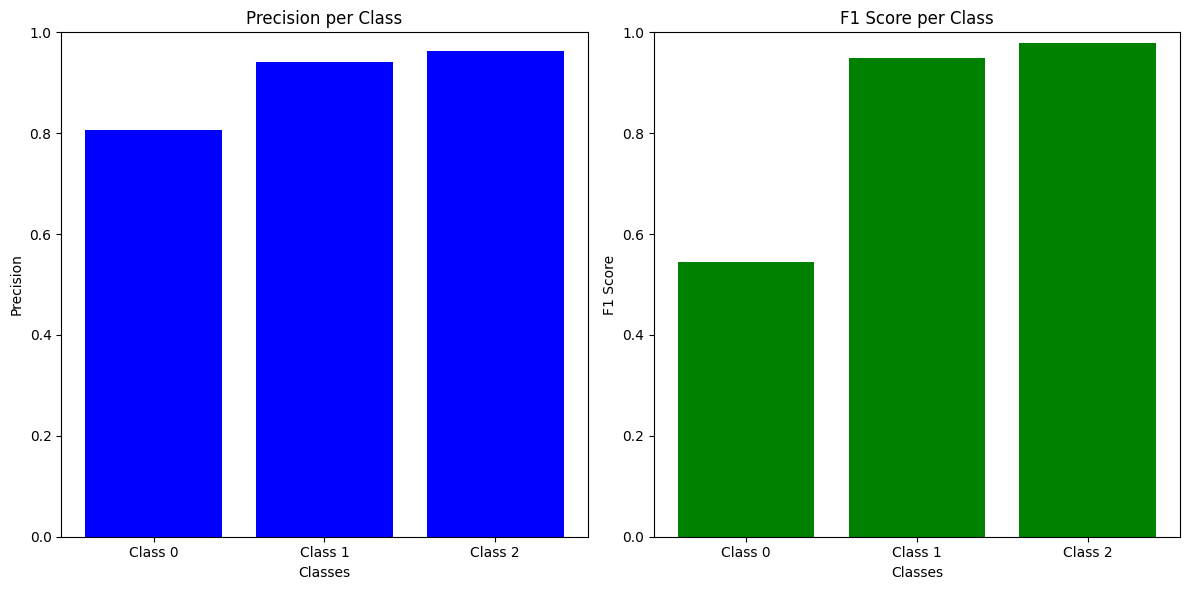

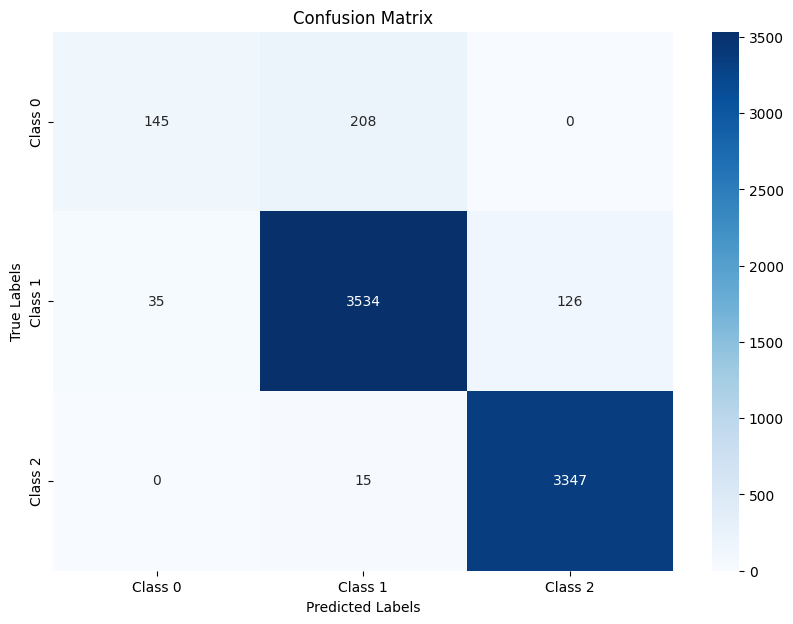

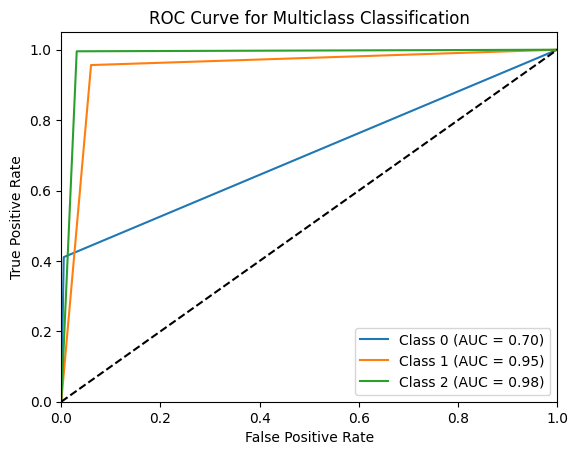

In [ ]:
# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


model = model.to(device)  # Move model to the appropriate device

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

model.eval()  # Set model to evaluation mode

# Initialize lists to store probabilities and labels
test_probs = []
test_preds = []
test_labels = []
test_label_list = []

# Testing loop
with torch.no_grad():  # Disable gradient computation
    for batch in test_loader:
        # Unpack batch data
        test_features, test_labels = batch
        
        test_features = test_features.to(device).float()
        test_labels = test_labels.to(device)
        
        # Forward pass
        outputs = model(test_features)
        
        # Apply softmax to get probabilities
        probs = F.softmax(outputs, dim=1)
        preds = probs.argmax(dim=1)
        
        # Store probabilities, predictions, and labels
        test_probs.append(probs.cpu())
        test_preds.append(preds.cpu())
        test_label_list.append(test_labels.cpu())

# Concatenate results across all batches
test_probs = torch.cat(test_probs)
test_preds = torch.cat(test_preds)
test_labels = torch.cat(test_label_list)

# Convert to numpy arrays for metrics calculation and saving
test_probs_np = test_probs.numpy()
test_preds_np = test_preds.numpy()
test_labels_np = test_labels.numpy()


# Calculate metrics
accuracy = accuracy_score(test_labels_np, test_preds_np)
precision = precision_score(test_labels_np, test_preds_np, average='weighted')
recall = recall_score(test_labels_np, test_preds_np, average='weighted')
f1 = f1_score(test_labels_np, test_preds_np, average='weighted')
conf_matrix = confusion_matrix(test_labels_np, test_preds_np)

# Print metrics
print(f'Final Test Metrics:\n')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Confusion Matrix:\n{conf_matrix}')

# Create a DataFrame to store results
test_prob_df = pd.DataFrame(test_probs_np, columns=[f'prob_class_{i}' for i in range(test_probs_np.shape[1])])
test_prob_df['predictions'] = test_preds_np
test_prob_df['labels'] = test_labels_np

# Save the results to an Excel file
test_prob_df.to_excel(os.path.join(exp_dir, 'test_data_predictions.xlsx'), index=False)

print('Testing Complete !!!')

# Calculate the AUC for all classes and plot ROC curves
num_classes = test_probs_np.shape[1]


plot_precision_f1(test_probs_np, test_labels_np, num_classes=3)

class_names = [f'Class {i}' for i in range(num_classes)]

# plot the confusion matrix
plot_confusion_matrix(test_labels_np, test_preds_np, class_names)

# plot_multiclass_roc(test_labels_np, test_preds_np)

### Model Evaluation on Test Data:

code...

### Model Evaluation on User Input:

code...

## Results:

(write about our findings and what the output of our model looks like)

## Challenges:

(write about the challenges faced during this project)

## Key Learnings:

(write about our key learnings and take-aways from this project)